In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from ema_workbench.analysis import pairs_plotting, plotting
from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis import feature_scoring
from ema_workbench.util.utilities import load_results

/Users/dategorter/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
/Users/dategorter/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
/Users/dategorter/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


In [2]:
results = load_results('50scenarios_6policies.tar.gz')
experiments, outcomes = results

## Exploratory results plotting
Start by taking the means of the 10 repetitions per experiment in order to not clutter the graphs.

In [3]:
experiments["general_willingness_to_share"] = experiments["general_willingness_to_share"].astype("category")
experiments["general_willingness_to_share"] = experiments["general_willingness_to_share"].cat.rename_categories(["low", "medium", "high"])
#experiments["price_per_bike"] = experiments_altered["general_willingness_to_share"].astype("category")

kpi_over_time = outcomes.keys()

outcomes_mean = {}
outcomes_mean_mean_across_time = {}
for outcome in kpi_over_time:
    outcomes_mean[outcome] = outcomes[outcome].mean(axis=1)
    outcomes_mean_mean_across_time[outcome] = outcomes_mean[outcome].mean(axis=1)

Initial exploration of the results by plotting the lines over time. Categorize by the different policies.

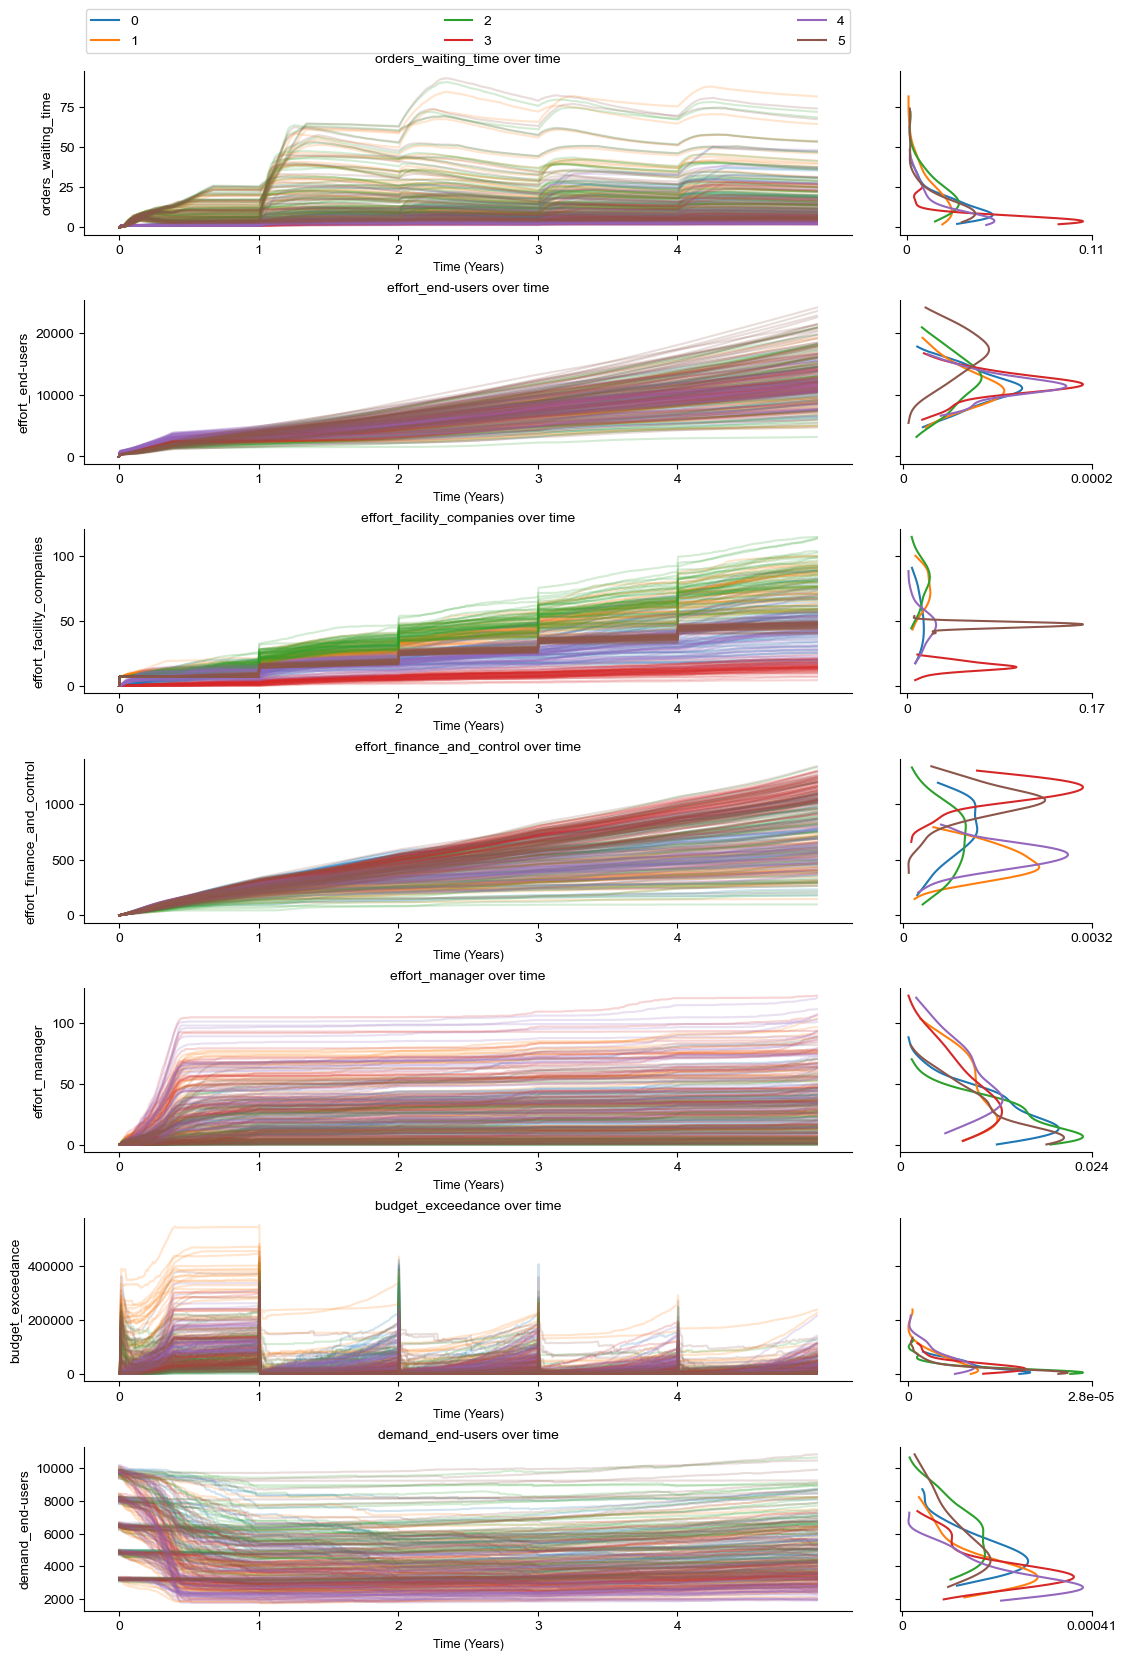

In [4]:
fig, axes = lines(experiments = experiments,
                  outcomes = outcomes_mean, 
                  group_by="policy",
                  density=plotting.Density.KDE )

fig.set_size_inches(13,20)

for ax in kpi_over_time:   
    axes[ax].set_xticks([0, 183, 2*183, 3*183, 4*183])
    axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()/183, dtype=int))
    axes[ax].set_ylabel(ax)
    axes[ax].set_xlabel("Time (Years)", size=9)
    axes[ax].set_title(f"{ax} over time", size=10)
    for line in axes[ax].get_lines():
        line.set_alpha(0.2)

sns.despine()
sns.set_theme()
plt.show()

In [5]:
fig.savefig('Outcomes_lines', dpi=fig.dpi, bbox_inches='tight')

## Global sensitivity analysis: Feature Scoring test

In [6]:
x = experiments
y = outcomes_mean
fs = feature_scoring.get_feature_scores_all(x, y)

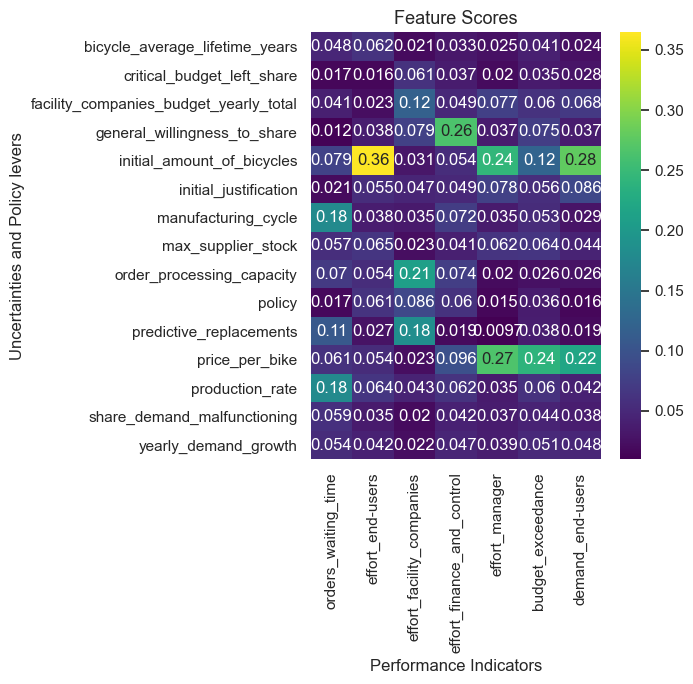

In [7]:
fig_sen, axes_sen = plt.subplots(figsize=(7, 7))
axes_sen = sns.heatmap(fs, annot=True,
                 cmap = 'viridis',)
axes_sen.tick_params('x')
axes_sen.set_title("Feature Scores", size=13)
axes_sen.set_xlabel("Performance Indicators", size = 12)
axes_sen.set_ylabel("Uncertainties and Policy levers", size=12)
plt.tight_layout()
plt.show()

In [8]:
fig_sen.savefig('Feature_score1', dpi=fig.dpi, bbox_inches='tight')

#### Large impact policy levers according to the global sensitivity analysis feature scoring:
<ul>
<li>Willingness to share -> 0.094 effort facility companies | 0.24 effort finance and control | 0.094 budget exceedance </li>
<li>fac_comp_budget -> 0.15 effort facility companies</li>
<li>order processing capacity -> 0.2 effort facility companies</li>
<li>predictive replacements -> 0.11 orders waiting time | 0.16 effort facility companies</li>
</ul>

## Policies disection

In [9]:
relevant_policies_df = experiments.iloc[:,8:].drop("scenario",axis=1).drop_duplicates().loc[:,["general_willingness_to_share",
                                                                        "facility_companies_budget_yearly_total",
                                                                        "order_processing_capacity",
                                                                        "predictive_replacements",
                                                                        "policy"]]

relevant_policies_df.facility_companies_budget_yearly_total = relevant_policies_df.facility_companies_budget_yearly_total.astype(np.int64)
relevant_policies_df.order_processing_capacity = relevant_policies_df.order_processing_capacity.astype(np.int64)

cm = sns.light_palette("green", as_cmap=True)
relevant_policies_df.reset_index(drop=True).style.background_gradient(cmap=cm, axis=0)
relevant_policies_df

,general_willingness_to_share,facility_companies_budget_yearly_total,order_processing_capacity,predictive_replacements,policy
0,medium,723054,3,False,0
50,high,631804,2,True,1
100,medium,955070,2,True,2
150,low,409024,5,False,3
200,high,449295,4,False,4
250,low,781279,1,True,5


## Cumulative plotting
Did not make the final thesis report as I was not satisfied by what the graph eventually shows. The final values always end-up at 25% of total effort for each of the agents as the end values are the highest due to the lineairity of the outcomes. More interesting would be to show the results as variance as opposed to the base case. This could be done in further work as time ran out for this project.

In [10]:
effort_keys = ['effort_end-users', 'effort_facility_companies', 'effort_finance_and_control', 'effort_manager']
ydict = {'effort_end-users':[], 
         'effort_facility_companies':[], 
         'effort_finance_and_control':[], 
         'effort_manager':[]}

for i in range(len(outcomes_mean[effort_keys[0]])):
    
    a = outcomes_mean[effort_keys[0]][i] #end_users
    b = outcomes_mean[effort_keys[1]][i] #fac_companies
    c = outcomes_mean[effort_keys[2]][i] #finance_control
    d = outcomes_mean[effort_keys[3]][i] #manager
                                 
    y1 = list((a-min(a))/(max(a)-min(a)))
    y2 = list((b-min(b))/(max(b)-min(b)))
    y3 = list((c-min(c))/(max(c)-min(c)))
    y4 = list((d-min(d))/(max([max(d),1])-min(d)))
    
    for i in range(len(y1)):
        total = y1[i] + y2[i] + y3[i] + y4[i]
        
        y1[i] = y1[i] / total
        y2[i] = y2[i] / total
        y3[i] = y3[i] / total
        y4[i] = y4[i] / total

    ydict['effort_end-users'].append(y1)
    ydict['effort_facility_companies'].append(y2)
    ydict['effort_finance_and_control'].append(y3)
    ydict['effort_manager'].append(y4)

<ipython-input-10-eddb2311f4da>:22: RuntimeWarning: invalid value encountered in double_scalars
  y1[i] = y1[i] / total
<ipython-input-10-eddb2311f4da>:23: RuntimeWarning: invalid value encountered in double_scalars
  y2[i] = y2[i] / total
<ipython-input-10-eddb2311f4da>:24: RuntimeWarning: invalid value encountered in double_scalars
  y3[i] = y3[i] / total
<ipython-input-10-eddb2311f4da>:25: RuntimeWarning: invalid value encountered in double_scalars
  y4[i] = y4[i] / total


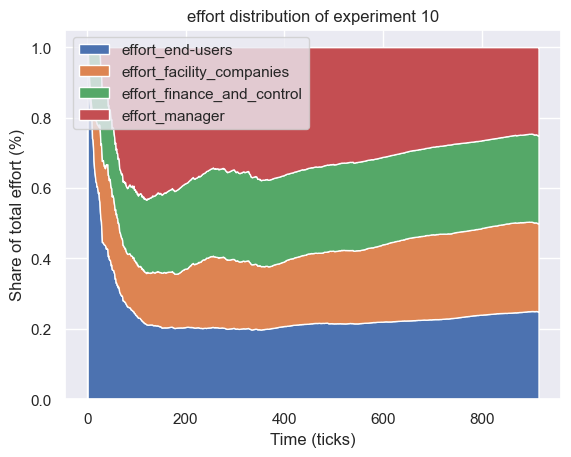

In [11]:
ydictplot = {}
experiment = 10

for i in ydict:
    ydictplot[i] = ydict[i][experiment]

x = range(len(ydictplot['effort_end-users']))

fig, ax = plt.subplots()
ax.stackplot(x, ydictplot.values(),
             labels=ydictplot.keys())
ax.legend(loc='upper left')
ax.set_title(f'effort distribution of experiment {experiment}')
ax.set_xlabel('Time (ticks)')
ax.set_ylabel('Share of total effort (%)')

plt.show()

## On predictive replacements policy

<ipython-input-12-1638b040d129>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figpred.tight_layout()


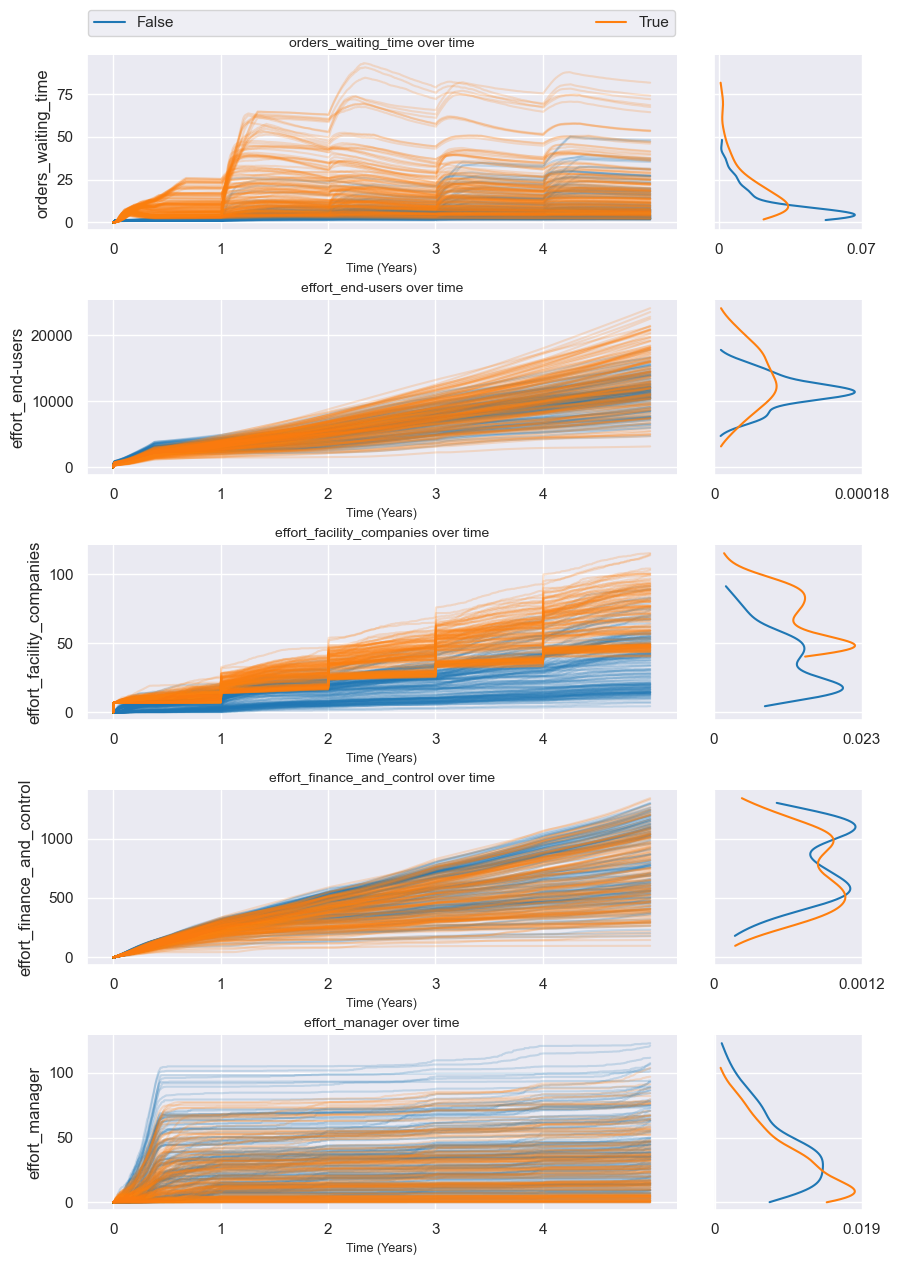

In [12]:
your_keys = ["orders_waiting_time",
             'effort_end-users', 
             'effort_facility_companies', 
             'effort_finance_and_control', 
             'effort_manager']
outcomes_mean_selection_owt_efc = { your_key: outcomes_mean[your_key] for your_key in your_keys }

figpred, axes = lines(experiments = experiments,
                  outcomes = outcomes_mean_selection_owt_efc, 
                  group_by="predictive_replacements",
                  density=plotting.Density.KDE )

figpred.set_size_inches(10,15)

for ax in outcomes_mean_selection_owt_efc.keys():   
    axes[ax].set_xticks([0, 183, 2*183, 3*183, 4*183])
    axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()/183, dtype=int))
    axes[ax].set_ylabel(ax)
    axes[ax].set_xlabel("Time (Years)", size=9)
    axes[ax].set_title(f"{ax} over time", size=10)
    for line in axes[ax].get_lines():
        line.set_alpha(0.2)

sns.despine()
figpred.tight_layout()
plt.show()

In [13]:
figpred.savefig('Prediction_policy', dpi=fig.dpi, bbox_inches='tight')

## On Willingness to share policy

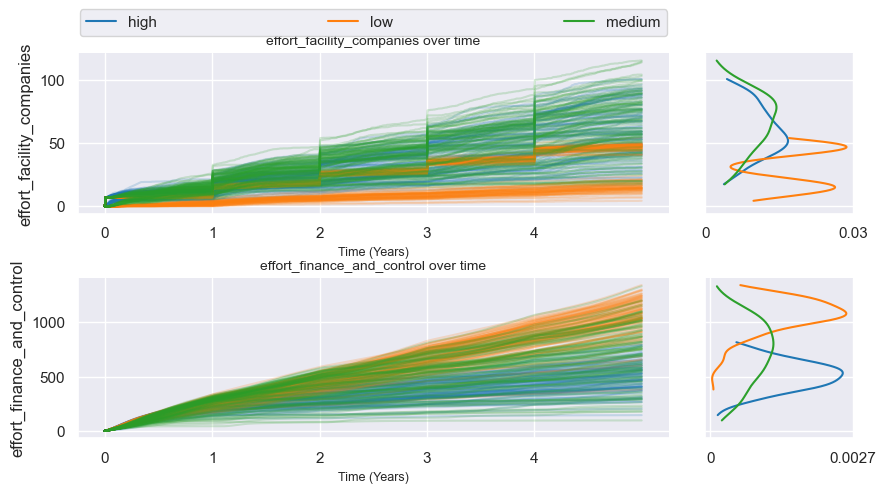

In [14]:
your_keys = [#"orders_waiting_time",
             #'effort_end-users', 
             'effort_facility_companies', 
             'effort_finance_and_control', 
             #'effort_manager', 
             #'budget_exceedance', 
             #'demand_end-users'
            ]

outcomes_mean_selection = { your_key: outcomes_mean[your_key] for your_key in your_keys }

fig3, axes = lines(experiments = experiments,
                  outcomes = outcomes_mean_selection, 
                  group_by="general_willingness_to_share",
                  density=plotting.Density.KDE )

fig3.set_size_inches(10,5)

for ax in outcomes_mean_selection.keys():   
    axes[ax].set_xticks([0, 183, 2*183, 3*183, 4*183])
    axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()/183, dtype=int))
    axes[ax].set_ylabel(ax)
    axes[ax].set_xlabel("Time (Years)", size=9)
    axes[ax].set_title(f"{ax} over time", size=10)
    for line in axes[ax].get_lines():
        line.set_alpha(0.2)
        
sns.despine()
plt.show()

In [15]:
fig3.savefig('Wilingness_policy', dpi=fig.dpi, bbox_inches='tight')

### Further vairance declaration within general willingness to share.
The bifurcation as seen in the previous graph where willingness to share = low. This is further explored in this section by plotting those lines, categorized by predictive replacements.

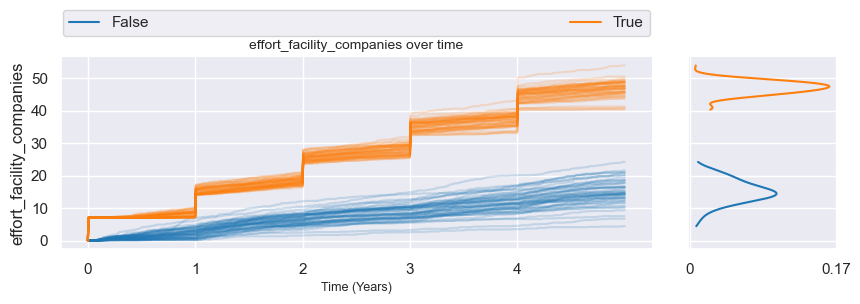

In [18]:
your_keys = [#"orders_waiting_time",
             #'effort_end-users', 
             'effort_facility_companies', 
             #'effort_finance_and_control', 
             #'effort_manager', 
             #'budget_exceedance', 
             #'demand_end-users'
            ]

experiments_selection = experiments[experiments["general_willingness_to_share"] == "low"]
outcomes_mean_selection = outcomes_mean
outcomes_mean_selection = { your_key: outcomes_mean[your_key][experiments_selection.index] for your_key in your_keys }


fig_effort_faccomp_wts_pred, axes = lines(experiments = experiments_selection,
                  outcomes = outcomes_mean_selection, 
                  group_by="predictive_replacements",
                  density=plotting.Density.KDE )

fig_effort_faccomp_wts_pred.set_size_inches(10,2.5)

for ax in outcomes_mean_selection.keys():   
    axes[ax].set_xticks([0, 183, 2*183, 3*183, 4*183])
    axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()/183, dtype=int))
    axes[ax].set_ylabel(ax)
    axes[ax].set_xlabel("Time (Years)", size=9)
    axes[ax].set_title(f"{ax} over time", size=10)
    for line in axes[ax].get_lines():
        line.set_alpha(0.2)
        
sns.despine()
plt.show()

In [19]:
fig_effort_faccomp_wts_pred.savefig('effort_faccomp_wts_pred', dpi=fig.dpi, bbox_inches='tight')

## Categorization by bicycle price

In [20]:
experiments_price_cat = experiments
experiments_price_cat["price_per_bike"] = pd.cut(experiments_price_cat["price_per_bike"], 3)

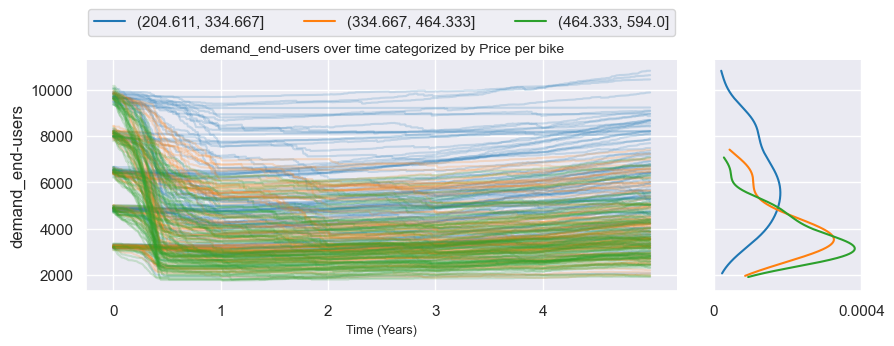

In [21]:
your_keys = [#"orders_waiting_time",
             #'effort_end-users', 
             #'effort_facility_companies', 
             #'effort_finance_and_control', 
             #'effort_manager',
             #'budget_exceedance', 
             'demand_end-users'
            ]

outcomes_mean_selection = { your_key: outcomes_mean[your_key] for your_key in your_keys }

fig, axes = lines(experiments = experiments_price_cat,
                  outcomes = outcomes_mean_selection, 
                  group_by="price_per_bike",
                  density=plotting.Density.KDE )

fig.set_size_inches(10,3)

for ax in outcomes_mean_selection.keys():   
    axes[ax].set_xticks([0, 183, 2*183, 3*183, 4*183])
    axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()/183, dtype=int))
    axes[ax].set_ylabel(ax)
    axes[ax].set_xlabel("Time (Years)", size=9)
    axes[ax].set_title(f"{ax} over time categorized by Price per bike", size=10)
    for line in axes[ax].get_lines():
        line.set_alpha(0.2)
     
    
#plt.legend(handles=[red_patch])
        
sns.despine()
plt.show()

In [22]:
fig.savefig('Demand_price', dpi=fig.dpi, bbox_inches='tight')